# Gathering Data for this Project  
Gather each of the three pieces of data as described below  
- 1.The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. Download this file manually by clicking the following link: twitter_archive_enhanced.csv

- 2.The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

- 3.Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

In [447]:
import pandas as pd
import numpy as np
import requests
import re

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

In [448]:
consumer_key = '<HIDDEN>'
consumer_secret = '<HIDDEN>'
access_token = '<HIDDEN>'
access_secret = '<HIDDEN>'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

## GATHER PART 1

In [449]:
df1 = pd.read_csv('twitter-archive-enhanced.csv')
df1.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


## GATHER PART 2

In [450]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
if response.status_code != 200:
    print('Failed to get data:', response.status_code)
else:
    with open('temp.txt', mode='wb' ) as file:
        file.write(response.content)
data = []
with open('temp.txt', encoding='utf-8') as file:
    columns = file.readline().split()
    print(columns)
    unsplited_data = file.readlines()
    for record in unsplited_data:
        d = record.split()
#         print(d)
        data.append(d)
#         print(data)
        
df2 = pd.DataFrame(data,columns=columns)
print(df2.shape)
df2.head()

['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
(2075, 12)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.07419169999999999,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.13858399999999998,True,bloodhound,0.11619700000000001,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## GATHER PART 3

In [451]:
tweet_ids = df1.tweet_id.values
print(len(tweet_ids))
print(tweet_ids)

2356
[892420643555336193 892177421306343426 891815181378084864 ...
 666033412701032449 666029285002620928 666020888022790149]


In [452]:
# %%time
# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
# #         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
# #             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
# #             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# # print(fails_dict)

In [453]:
df_list=[]
with open('tweet_json.txt') as file:
    
    lines = file.readlines()
    for line in lines:
        d = json.loads(line)
        tweet_id=d["id"]
        retweet_count=d["retweet_count"]
        favorite_count=d["favorite_count"]
        df_list.append({"tweet_id":tweet_id,
                       "retweet_count":retweet_count,
                       "favorite_count":favorite_count})
                
        
df3 = pd.DataFrame(df_list)
df3.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7314,34837
1,892177421306343426,5465,30181
2,891815181378084864,3606,22725
3,891689557279858688,7497,38085
4,891327558926688256,8056,36359


# Assessing Data for this Project  
After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.

### DF1

In [454]:
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [455]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [456]:
df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [457]:
df1.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [458]:
df1.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1749,679047485189439488,NaN,NaN,2015-12-21 21:15:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog doesn't know how to stairs. Quite tra...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679047485...,9,10,None,None,None,None,None
937,753298634498793472,NaN,NaN,2016-07-13 18:42:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Carly. She's actually 2...,6.815232e+17,4.196984e+09,2015-12-28 17:12:42 +0000,https://twitter.com/dog_rates/status/681523177...,12,10,Carly,None,None,None,None
1741,679475951516934144,NaN,NaN,2015-12-23 01:37:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Evy. She doesn't want to be a Koala. 9...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679475951...,9,10,Evy,None,None,None,None
2031,671768281401958400,NaN,NaN,2015-12-01 19:10:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you try to recreate the scene from Lady &...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671768281...,10,10,None,None,None,None,None
1302,707610948723478529,NaN,NaN,2016-03-09 16:56:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Harper. She scraped her elbow attempti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707610948...,12,10,Harper,None,None,None,None


In [459]:
df1.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Jim          1
Arlo         1
Cuddles      1
Suki         1
Autumn       1
Name: name, Length: 957, dtype: int64

### DF2

In [460]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2075 non-null   object
 1   jpg_url   2075 non-null   object
 2   img_num   2075 non-null   object
 3   p1        2075 non-null   object
 4   p1_conf   2075 non-null   object
 5   p1_dog    2075 non-null   object
 6   p2        2075 non-null   object
 7   p2_conf   2075 non-null   object
 8   p2_dog    2075 non-null   object
 9   p3        2075 non-null   object
 10  p3_conf   2075 non-null   object
 11  p3_dog    2075 non-null   object
dtypes: object(12)
memory usage: 194.7+ KB


In [461]:
df2.describe()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
count,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075
unique,2075,2009,4,378,2006,2,405,2004,2,408,2006,2
top,675362609739206656,https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.0693617,True,Labrador_retriever,0.22326300000000002,True
freq,1,2,1780,150,2,1532,104,3,1553,79,2,1499


In [462]:
df2.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
238,670434127938719744,https://pbs.twimg.com/media/CU3cSG8W4AIAePH.jpg,1,jack-o'-lantern,0.91914,False,Chesapeake_Bay_retriever,0.027351,True,Labrador_retriever,0.020080900000000002,True
703,684914660081053696,https://pbs.twimg.com/media/CYFOP6cWEAAWp-k.jpg,1,shopping_cart,0.46095,False,chow,0.261288,True,Labrador_retriever,0.0741938,True
1163,735137028879360001,https://pbs.twimg.com/media/CjO7OfeWgAAUQy-.jpg,1,Walker_hound,0.41353500000000004,True,beagle,0.233891,True,English_foxhound,0.164943,True
84,667502640335572993,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,1,Labrador_retriever,0.9967090000000001,True,golden_retriever,0.00168821,True,beagle,0.0007116669999999999,True
1748,823581115634085888,https://pbs.twimg.com/media/C23ypm6VQAAO31l.jpg,1,dingo,0.280949,False,German_shepherd,0.194044,True,Pembroke,0.120051,True


### DF3

In [463]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [464]:
df3.describe()

,tweet_id,retweet_count,favorite_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,2572.805663,7275.503647
std,6.823170e+16,4351.987029,11300.095622
min,6.660209e+17,1.000000,0.000000
25%,6.782670e+17,522.000000,1259.000000
50%,7.182469e+17,1198.000000,3153.000000
75%,7.986692e+17,2979.500000,8888.500000
max,8.924206e+17,73812.000000,149660.000000


In [465]:
df3.sample(5)

,tweet_id,retweet_count,favorite_count
589,798209839306514432,2497,10239
1562,686760001961103360,1318,3366
2099,670374371102445568,248,693
733,778990705243029504,6941,19419
2320,666063827256086533,186,426


## ASSESS Quality  
### `DF1` Dataframe
- tweet_id is int not string
- in_reply_to_status_id , in_reply_to_user_id is float not string
- timestamp,retweeted_status_timestamp is object not datetime
- Columns like : in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls has missing data.
- rating_denominator column for one record is 0 , which is incorrect
- Many non-dog name values in name column , which seems a data quality issue.

### `DF3` Dataframe
- tweet_id is int

## ASSESS Tidiness
- The dog `stage` is one variable and hence should form single column. But this variable is spread across 4 columns - doggo, floofer, pupper, puppo.
- Information about one type of observational unit (tweets) is spread across three different files/dataframes.Hence these 3 dataframes are menged into one
- DF1 numerator and denominator should be combined to create one fraction value and drop both the columns.


# Cleaning Data for this Project
Clean each of the issues you documented while assessing. Perform this cleaning in wrangle_act.ipynb as well. The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate). Again, the issues that satisfy the Project Motivation must be cleaned.

In [466]:
df1_clean=df1.copy()
df2_clean=df2.copy()
df3_clean=df3.copy()

In [467]:
df1_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [468]:
df2_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.07419169999999999,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.13858399999999998,True,bloodhound,0.11619700000000001,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [469]:
df3_clean.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7314,34837
1,892177421306343426,5465,30181
2,891815181378084864,3606,22725
3,891689557279858688,7497,38085
4,891327558926688256,8056,36359


## Changing tweet_id from int to string

### Define  
Changing the twwet_id from int to string for the dataframe : DF1 & DF3

### Code

In [470]:
df1_clean['tweet_id'] = df1_clean['tweet_id'].apply(str)
df3_clean['tweet_id'] = df3_clean['tweet_id'].apply(str)

### Test  
dtype('O') confirms it to be of object type

In [471]:
df1_clean.tweet_id.dtype , df3_clean.tweet_id.dtype

(dtype('O'), dtype('O'))

## Joining the 3 Dataframes

### Define  
Information about one type of observational unit (tweets) is spread across three different files/dataframes.Hence these 3 dataframes are merged into one. tweet_id is used as the joining 'on' variable.

### Code

In [472]:
# Joining the 3 Dataframes on tweet_id
df_temp = pd.merge(df1_clean,df2_clean,on='tweet_id',how='left')
final_df = pd.merge(df_temp,df3_clean,on='tweet_id',how='left')

### Test

In [473]:
print(f'Shapes of the 3 and combined dataframes are as below :\n DF1 : {df1_clean.shape} , DF2 : {df2_clean.shape} , DF3 : {df3_clean.shape} , Final DF : {final_df.shape}')

Shapes of the 3 and combined dataframes are as below :
 DF1 : (2356, 17) , DF2 : (2075, 12) , DF3 : (2331, 3) , Final DF : (2356, 30)


In [474]:
final_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

## More Conversions from int/float to string

### Define  
Converting in_reply_to_status_id , in_reply_to_user_id to str

### Code

In [475]:
# in_reply_to_status_id , in_reply_to_user_id to str
final_df['in_reply_to_status_id'] = final_df['in_reply_to_status_id'].apply(str)
final_df['in_reply_to_user_id'] = final_df['in_reply_to_user_id'].apply(str)

### Test  
All the above columns are now changed

In [476]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   object 
 1   in_reply_to_status_id       2356 non-null   object 
 2   in_reply_to_user_id         2356 non-null   object 
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## Conversion to Datetime

### Define  
Variables such as timestamp,retweeted_status_timestamp which represent time are best candidate for datetime conversion since it opens wide variety of data manipulation opportunity by using datatime functions and `.dt` and calculations are done easily.

### Code

In [477]:
# timestamp,retweeted_status_timestamp is object not datetime
final_df['timestamp'] =  pd.to_datetime(final_df['timestamp'], format='%Y%m%d %H:%M:%S')
final_df['retweeted_status_timestamp'] =  pd.to_datetime(final_df['retweeted_status_timestamp'], format='%Y%m%d %H:%M:%S')

### Test

In [478]:
final_df.timestamp.dtype , final_df.retweeted_status_timestamp.dtype

(datetime64[ns, UTC], datetime64[ns, UTC])

## Handling 0 in rating_denominator

### Define  
In the Project overview it says "These ratings almost always have a denominator of 10." , So I am assuming other values could make sense but having 0 in denominator is mathematically incorrect , Highly likely it should have been '10' which is the most frequent value.


### Code

In [479]:
# final_df['rating_denominator'].value_counts()
final_df[final_df['rating_denominator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
313,835246439529840640,8.35245984028504e+17,26259576.0,2017-02-24 21:54:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,2037.0


In [480]:
final_df.loc[(final_df.rating_denominator == 0),'rating_denominator']=10

### Test

In [481]:
final_df[final_df['rating_denominator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


## Creating one fraction value

### Define 
rating_numerator and rating_denominator should be combined to create one fraction value

### Code

In [482]:
final_df['rating_fraction']=final_df.rating_numerator/final_df.rating_denominator
final_df.drop(['rating_numerator','rating_denominator'],inplace=True,axis=1)

### Test

In [483]:
final_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,rating_fraction
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.08585110000000001,False,banana,0.07611,False,7314.0,34837.0,1.3
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.0906465,True,papillon,0.0689569,True,5465.0,30181.0,1.3
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.0313789,True,3606.0,22725.0,1.2
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.16808599999999999,True,spatula,0.0408359,False,7497.0,38085.0,1.3
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.22576999999999997,True,German_short-haired_pointer,0.175219,True,8056.0,36359.0,1.2


## Remove Re-tweets

### Define  
Removed all rows that have values (not blank or non-null) in retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns post which removed retweet-related columns 

### Code

In [484]:
mask = final_df.retweeted_status_id.isnull() & final_df.retweeted_status_user_id.isnull() & final_df.retweeted_status_timestamp.isnull()
final_df = final_df[mask]
final_df.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1,inplace=True)

### Test

In [485]:
final_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,rating_fraction
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,None,None,...,False,bagel,0.08585110000000001,False,banana,0.07611,False,7314.0,34837.0,1.3
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,None,None,...,True,Pekinese,0.0906465,True,papillon,0.0689569,True,5465.0,30181.0,1.3
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,None,None,...,True,malamute,0.078253,True,kelpie,0.0313789,True,3606.0,22725.0,1.2
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,None,None,...,False,Labrador_retriever,0.16808599999999999,True,spatula,0.0408359,False,7497.0,38085.0,1.3
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,None,None,...,True,English_springer,0.22576999999999997,True,German_short-haired_pointer,0.175219,True,8056.0,36359.0,1.2


## Remov Non-Dog Names

### Define  
Many non-dog names in name column such as 'a', 'such', 'the', 'just', 'getting' etc , they need to be cleaned up.

### Code

In [486]:
mask = final_df.name.str.islower()
final_df.loc[mask,'name']=np.nan

### Test

In [487]:
final_df.name.str.islower().sum()

0

## Creating `stage` column 

### Define  
The dog stage is one variable and hence should form single column. But this variable is spread across 4 columns - doggo, floofer, pupper, puppo.

### Code

In [488]:
final_df.doggo.replace('None', '', inplace=True)
final_df.floofer.replace('None', '', inplace=True)
final_df.pupper.replace('None', '', inplace=True)
final_df.puppo.replace('None', '', inplace=True)

In [489]:
final_df['stage'] = final_df.doggo + '-' + final_df.floofer+ '-'  + final_df.pupper+ '-'  + final_df.puppo

In [490]:
final_df.stage.value_counts()

---                1831
--pupper-           224
doggo---             75
---puppo             24
doggo--pupper-       10
-floofer--            9
doggo-floofer--       1
doggo---puppo         1
Name: stage, dtype: int64

In [491]:
final_df['stage'] = final_df['stage'].str.strip('-')

In [492]:
def myreplace(string):
    pattern = '-' + '{2,}'
    string = re.sub(pattern,'-', string)
    return string
final_df.stage = final_df.stage.apply(myreplace)

### Test

In [493]:
final_df.stage.value_counts()

                 1831
pupper            224
doggo              75
puppo              24
doggo-pupper       10
floofer             9
doggo-puppo         1
doggo-floofer       1
Name: stage, dtype: int64

# Storing, Analyzing, and Visualizing Data for this Project  
Store the clean DataFrame(s) in a CSV file with the main one named `twitter_archive_master.csv`. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).

Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. At least **three (3) insights and one (1) visualization** must be produced.

In [494]:
final_df.to_csv('twitter_archive_master.csv',header=True,index=False)

In [495]:
# Insight 1 : Most Common Name for Dogs is Charlie
final_df.name.value_counts()

None        680
Charlie      11
Lucy         11
Oliver       10
Cooper       10
           ... 
Samsom        1
Dietrich      1
Keet          1
Jiminus       1
Autumn        1
Name: name, Length: 931, dtype: int64

In [496]:
# Trend in retweet_count & Favourite count

In [497]:
final_df['time_stamp_month_year'] = final_df['timestamp'].dt.strftime('%Y-%m')

In [498]:
insight_2_df = final_df[['time_stamp_month_year','favorite_count','retweet_count']].groupby(['time_stamp_month_year']).sum().reset_index()
insight_2_df['time_stamp_month_year'] =  pd.to_datetime(insight_2_df['time_stamp_month_year'], format='%Y%m%d %H:%M:%S')
insight_2_df.head()

,time_stamp_month_year,favorite_count,retweet_count
0,2015-11-01,336111.0,137916.0
1,2015-12-01,1206732.0,492916.0
2,2016-01-01,696711.0,260067.0
3,2016-02-01,456669.0,162526.0
4,2016-03-01,548622.0,197263.0


<AxesSubplot:xlabel='time_stamp_month_year', ylabel='favorite_count'>

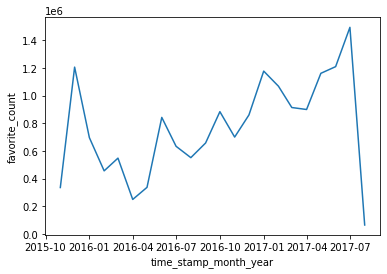

In [499]:
# Visuzlizing the trend
import seaborn as sns
sns.lineplot(data=insight_2_df, x="time_stamp_month_year", y="favorite_count")

<AxesSubplot:xlabel='time_stamp_month_year', ylabel='retweet_count'>

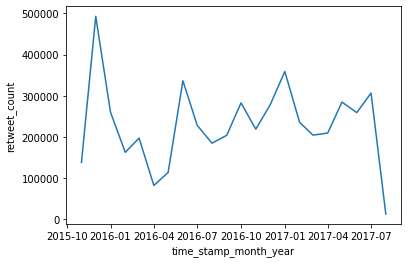

In [500]:
sns.lineplot(data=insight_2_df, x="time_stamp_month_year", y="retweet_count")